# Libraries

In [266]:
#---------------------------------------------------------------------------------------------------------------------
#warnings
import warnings
warnings.filterwarnings('ignore')

#---------------------------------------------------------------------------------------------------------------------
#data analysis and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")


#---------------------------------------------------------------------------------------------------------------------
#linear modelling
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lazypredict.Supervised import LazyRegressor


#---------------------------------------------------------------------------------------------------------------------
#classification modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier


#---------------------------------------------------------------------------------------------------------------------
#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as st #for boxcox


#---------------------------------------------------------------------------------------------------------------------
#model metrics
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score


#---------------------------------------------------------------------------------------------------------------------
#feature selection
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif


#---------------------------------------------------------------------------------------------------------------------
#outliers
from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN


#---------------------------------------------------------------------------------------------------------------------
#model selection
from sklearn.model_selection import cross_val_score, GridSearchCV


# Helping Functions

In [242]:
"""
#---------------------------------------------------------------------------------------------------------------------
#warnings
import warnings
warnings.filterwarnings('ignore')

#---------------------------------------------------------------------------------------------------------------------
#data analysis and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")


#---------------------------------------------------------------------------------------------------------------------
#linear modelling
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lazypredict.Supervised import LazyRegressor


#---------------------------------------------------------------------------------------------------------------------
#classification modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier


#---------------------------------------------------------------------------------------------------------------------
#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as st #for boxcox


#---------------------------------------------------------------------------------------------------------------------
#model metrics
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score


#---------------------------------------------------------------------------------------------------------------------
#feature selection
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif


#---------------------------------------------------------------------------------------------------------------------
#outliers
from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN


#---------------------------------------------------------------------------------------------------------------------
#model selection
from sklearn.model_selection import cross_val_score, GridSearchCV


"""

#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','R2-Score','RMSE-Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Lasso
    model = Lasso()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Lasso'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Ridge
    model = Ridge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Ridge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #KernelRidge
    model = KernelRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #ElasticNet
    model = ElasticNet()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)


    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Lasso
    model = Lasso()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Lasso'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Ridge
    model = Ridge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Ridge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #KernelRidge
    model = KernelRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #ElasticNet
    model = ElasticNet()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    models_summary['R2-Score']=models_summary['R2-Score'].round(3)
    models_summary['RMSE-Score']=models_summary['RMSE-Score'].round(3)
            
    model_summary = models_summary.sort_values(by=['RMSE-Score'],ascending=True)
    model_summary.reset_index(inplace=True)
    return model_summary


def m_mlog_regression(xtr, xts, ytr, yts):
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])
    
    #Logistic regression
    model=LogisticRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Logistic'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Kneighbors classifier
    model=KNeighborsClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Kneighbors'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Gaussian NB
    model=GaussianNB()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='GaussianNB'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Support Verctor Classifier
    model=SVC()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='SVC'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Decision Tree Classifier
    model=DecisionTreeClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='DecisionTree'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Random Forest Classifier
    model=RandomForestClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='RandomForest'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #XGB Classifier
    model=XGBClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='XGB Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #LGBM Classifier
    model=LGBMClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='LGBM Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #CatBoost Classifier()
    model=CatBoostClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='CatBoost Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    models_summary = models_summary.sort_values(by=['Score'],ascending=False)
    models_summary.reset_index(inplace=True)

    return models_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#list the features which have correlation of specific values against the rest of dataset features
def m_corr_list(df,min_up=0.6,min_down=-0.6):
    corr_mat=df.corr()
#loop through orrelation-matrix rows
    for x in corr_mat.index:
        #list for features having positive correlation against first feature
        corr_feat_up=[]
        #list for features having negative correlation against first feature
        corr_feat_down=[]
        
        #add features which have correlation in the specified limits
        for y in corr_mat.columns:
            if (corr_mat.loc[x,y]>=min_up) and (x!=y): #skip feature against same feature
                corr_feat_up.append(y)
            elif (corr_mat.loc[x,y]<=min_down) and (x!=y): #skip feature against same feature
                corr_feat_down.append(y)
        if len(corr_feat_up)!=0:
            print ('\033[1m'+x+'\033[0m'+' is positively correlated with {}'.format(corr_feat_up))
        if len(corr_feat_down)!=0:
            print ('\033[1m'+x+'\033[0m'+' is negatively correlated with {}'.format(corr_feat_down))
        if len(corr_feat_up)!=0 or len(corr_feat_down)!=0:
            print ('')           

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#split dataframe into target variable and features
def m_xy_split(df,target_column):
    col = (df.columns).drop(target_column)
    y = df[[target_column]]
    x = df[col]
    return x,y

def m_scale_encode_split(dftrain,target_feature,num_feature,cat_feature,train_size=0.85,dftest=None,encode_target=0):
    """
    ** Returns xtr_sc,xts_sc,ytr,yts,dfts_sc
    ** dftest is not none: will scale test dataset at same scale of training dataset
    ** To encode target variable, encode_target=1
    """
    #separating target variable and features
    df=dftrain
    y_ml=df[target_feature]
    x_ml=df[num_feature+cat_feature]

    #Encoding categorical features
    x_ml_dum = pd.get_dummies(x_ml,columns=cat_feature,drop_first=True)
    
    if encode_target==1:
        y_ml_dum=pd.get_dummies(y_ml,drop_first=True)
        y_ml=y_ml_dum.copy()

    #splitting data
    xtr,xts,ytr,yts=train_test_split(x_ml_dum,y_ml,train_size=train_size)

    #Scaling numerical features
    xtr_sc=xtr.copy()
    xts_sc=xts.copy()
    sc=StandardScaler()
    xtr_sc[num_feature]=sc.fit_transform(xtr[num_feature])
    xts_sc[num_feature]=sc.transform(xts[num_feature])
    
    
    if dftest is None:
        return xtr_sc,xts_sc,ytr,yts
    
    else:
        dfts=dftest[num_feature+cat_feature]
        dfts_dum = pd.get_dummies(dfts,columns=cat_feature,drop_first=True)
        dfts_sc=dfts_dum.copy()
        dfts_sc[num_feature]=sc.transform(dfts_sc[num_feature])
        
        return xtr_sc,xts_sc,ytr,yts,dfts_sc

#from collections import Counter #for IQR method
def m_outlier_iqr (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_std (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers   

#from scipy.stats import median_abs_deviation #for modified z-score
def m_outlier_zscore (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_zscore_modified (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )
                
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[mod_z_score >threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

#from sklearn.ensemble import IsolationForest
def m_outlier_isolationforest(df,features=[]):
    df=df[features]
    outlier_model = IsolationForest()
    outlier_model.fit(df)
    anomaly = outlier_model.predict(df)
    df['anomaly'] = anomaly
    print ('The total number of outliers is: ',df[(df['anomaly']==-1)]['anomaly'].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(df[(df['anomaly']==-1)]['anomaly'].count()/df.shape[0]*100,0)))

    return df

#from sklearn.cluster import DBSCAN
def m_outlier_DBSCAN(df,features=[]):
    df=df[features]
    sc = StandardScaler()
    df_sc = sc.fit_transform(df)
    model_DBSCAN = DBSCAN()
    model_DBSCAN.fit(df_sc)
    labels = model_DBSCAN.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    labels = pd.Series(labels)
    print ('The total number of clusters without outliers: ',n_clusters)
    print ('The number of outliers is: ',labels[(labels==-1)].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(labels[(labels==-1)].count()/df.shape[0]*100,0)))           
    df['label']=labels
    return df

#perfrom all outliers detection methods
def m_outlier_all (df,n,features=[]):
    
    print ("Method IQR:")
    out_iqr = m_outlier_iqr(df,n=n,features=features)
    print ("\nMethod Standard deviation:")
    out_std = m_outlier_std(df,n=n,features=features)
    print ("\nMethod Z-Score:")
    out_zsc = m_outlier_zscore(df,n=n,features=features)
    print ("\nMethod Modified Z-Score:")
    out_mzs = m_outlier_zscore_modified(df,n=n,features=features)
    print ("\nMethod Isolation forest:")
    df_isf = m_outlier_isolationforest(df,features=features)
    out_isf = list(df_isf[(df_isf['anomaly']==-1)].index)
    print ("\nMethod DBSCAN:")
    df_dbscan = m_outlier_DBSCAN(df,features=features)
    out_dbs = list(df_dbscan[(df_dbscan['label']==-1)].index)
    
    out_total = set(out_iqr).intersection(out_std,out_zsc,out_mzs,out_dbs,out_isf)
    print (100*'-')
    print('Total number of outliers confirmed by all methods is: {} '.format(len(out_total)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(out_total)/df.shape[0]*100,0)))
    
    return out_total
    
#Fast EDA
class m_describe:
    def __init__(self,dataframe):
        self.dataframe=df

    def show_main (df,export_notes=False):
        df=df
        print ("Total number of features: ", len(df.columns))
        print ("Total number of observations: ", len(df))
        print ('-'*70)
        print ('Total number of numerical values: ',len(list(df.select_dtypes(include=['int64', 'float64']).columns)))
        print ('Total number of categorical values: ',len(list(df.select_dtypes(include=['object']).columns)))
        print ('-'*70)
        print ("Total number of missing values: ", df.isnull().sum().sum())
        print ("Total number of duplicate rows: ", df.duplicated().sum())
        plt.pie(x=[len(list(df.select_dtypes(include=['int64', 'float64']).columns)),
                   len(list(df.select_dtypes(include=['object']).columns))],
               labels=['Numerical Features','Categorical Features'],autopct='%1.0f%%')
        plt.title('Features Types')
             
        #export features_notes 
        if export_notes==True:
            x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
            cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
            cat_df['Type']='Categorical'

            y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
            num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
            num_df['Type']='Numerical'

            fea_df = pd.concat([num_df, cat_df]) #merge above dataframes
            fea_df[['Description','Importance','Observation','To Do']]=""
            fea_df.to_excel('notes.xlsx',index=False)
            del x,y,fea_df

    
    #returns a list of numerical values
    def num(df):
        df=df
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    #returns a list of categorical values
    def cat(df):
        df=df
        return list(df.select_dtypes(include=['object']).columns)
    
    #returns a list of missing values sorted from high to low and categorized by features 
    def missing_val_list(df):
        df=df
        x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
        cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
        cat_df['Type']='Categorical'

        y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
        num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
        num_df['Type']='Numerical'

        fea_df = pd.concat([num_df, cat_df]) #merge above dataframes

        x= list(df.columns) #get list of all features
        y= list(np.round(df.isnull().sum()/len(df)*100,0)) #get % of null values of all features
        z= list((df.isnull().sum())) #get sum of null values of all features
        nul_df = pd.DataFrame({'Feature':x,'count of nulls':z,'null % of total obesrvations':y}) #create dataframe from x,y,z

        nul_df = pd.merge(fea_df,nul_df,on='Feature',how='outer') #merge all dataframes
        nul_df=nul_df[(nul_df['count of nulls']>0)] #show only features having null values
        nul_df.sort_values(by=['Type','null % of total obesrvations'],ascending=False) #sorting
        nul_df=nul_df.reset_index(drop=True) #drop index
        del x,y,z,cat_df,num_df #delete all temporary variables
        return nul_df 
    
    #visualize numerical feauters
    def visualize_num(df,
                      features='all',
                     figure_size=(15,150),color=sns.color_palette('Set2')[0]):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['int64', 'float64']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range(len(features)):
            sns.histplot(data=df[features[i]],color=color,ax=a[i,0])
            sns.boxplot(y=df[features[i]],color=color,ax=a[i,1])
        del features
        #return fig
        
    #visualize categorical features
    def visualize_cat(df,
                      features='all',
                      figure_size=(15,150), color_scheme='Set2'):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range (len(features)):
            sorted_labels=df[features[i]].value_counts().sort_values(ascending=False).index
            sns.countplot(df[features[i]],palette=color_scheme,order=sorted_labels,ax=a[i,0])
            a[i,1].pie(df[features[i]].value_counts(),labels=list(sorted_labels),autopct='%1.0f%%',colors=sns.color_palette(sns.color_palette(color_scheme)));
        del features, sorted_labels
        #return fig
    
    #visulalize numerical features against target feature
    def visualize_num_tar(df,target,features='all',figure_size=(5,10), color_scheme='Set2'):
        df=df
        target=target
        if features == 'all':
            features=list(df.select_dtypes(exclude=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=1,figsize=figure_size)
        for i in range (len(features)):
            sns.histplot(data=df, x=features[i], hue=target,palette=color_scheme);
            a[i].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
        #return fig

    #visualize categorical features against target featurs
    def visualize_cat_tar(df,target,features='all',figure_size=(5,20), color_scheme='Set2'):
        df=df
        target=target
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=1,figsize=figure_size)
        for i in range (len(features)):
            sns.countplot(data=df, x=features[i],hue=target,ax=a[i],palette=color_scheme);
            a[i].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
        #return fig

    
    #show first 
    def show_category_concentration(df,min_percent=0.95):
        #create auxilary dataframe
        x=pd.DataFrame(df.nunique(),columns=['Unique values'])
        x=x.reset_index()
        #add new column -feature
        x=x.rename(columns={'index':'Feature'})
        x= x.sort_values(by='Unique values',ascending=True)

        #get list of features
        list_of_features=list(x['Feature'].unique())
        #loop through all feature and get percentage of data in the top category
        for i in range(len(list_of_features)):
            feature=list_of_features[i]
            n_unique = df[feature].nunique()
            value_counts = df[feature].value_counts()
            percentage=np.round(value_counts.max() / value_counts.sum()*100)
            x.loc[x['Feature']==feature, '1st category concentration -%'] = percentage
        x=x[x['1st category concentration -%']/100>=min_percent]
        x = x.sort_values(by=['Unique values','1st category concentration -%'],ascending=[True,False])
        x=x.reset_index(drop=True)
        return x


# Importing data

In [4]:
dtr= pd.read_csv('train.csv')
dts= pd.read_csv('test.csv')

In [5]:
df1= dtr.copy()
df2= dts.copy()

In [6]:
df1.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [7]:
df2.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers


In [8]:
#I'm going to merge both train and test for further EDA
df3=pd.concat([df1,df2])
df1.shape,df2.shape,df3.shape

((8693, 14), (4277, 13), (12970, 14))

## Exploratory Data Analysis

Total number of features:  14
Total number of observations:  12970
----------------------------------------------------------------------
Total number of numerical values:  6
Total number of categorical values:  8
----------------------------------------------------------------------
Total number of missing values:  7718
Total number of duplicate rows:  0


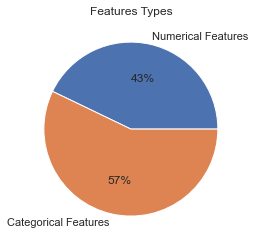

In [9]:
m_describe.show_main(df3,export_notes=False)

I want to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly by analyzing the following features: 
* Age<br>
* RoomService<br>
* FoodCourt<br>
* ShoppingMall<br>
* Spa<br>
* VRDeck<br>
* PassengerId<br>
* HomePlanet<br>
* CryoSleep<br>
* Cabin<br>
* Destination<br>
* VIP<br>
* Name<br>
 

## Investigating missing values

In [10]:
m_describe.missing_val_list(df1)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,179,2.0
1,RoomService,Numerical,181,2.0
2,FoodCourt,Numerical,183,2.0
3,ShoppingMall,Numerical,208,2.0
4,Spa,Numerical,183,2.0
5,VRDeck,Numerical,188,2.0
6,HomePlanet,Categorical,201,2.0
7,CryoSleep,Categorical,217,2.0
8,Cabin,Categorical,199,2.0
9,Destination,Categorical,182,2.0


In [11]:
m_describe.missing_val_list(df2)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,91,2.0
1,RoomService,Numerical,82,2.0
2,FoodCourt,Numerical,106,2.0
3,ShoppingMall,Numerical,98,2.0
4,Spa,Numerical,101,2.0
5,VRDeck,Numerical,80,2.0
6,HomePlanet,Categorical,87,2.0
7,CryoSleep,Categorical,93,2.0
8,Cabin,Categorical,100,2.0
9,Destination,Categorical,92,2.0


in both training and testing dataset, we have missing values in all features except the predicted value (Transported) which is complete in training dataset, let's examine full dataset features

## Visualizing dataset features

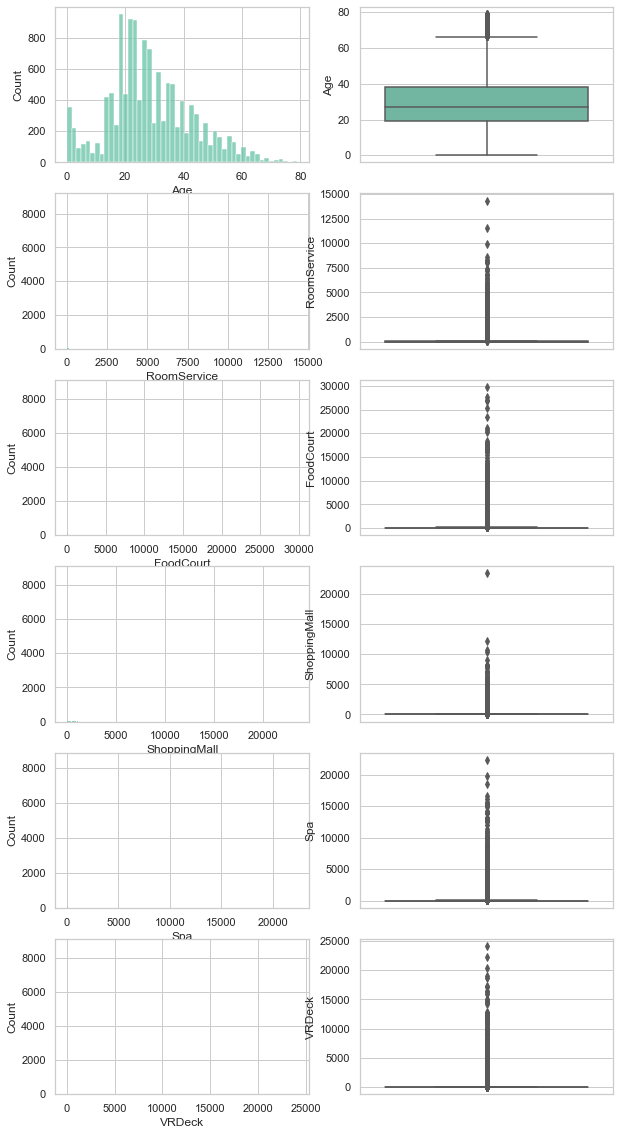

In [12]:
num = m_describe.num(df3)
m_describe.visualize_num(df3,features=num,figure_size=(10,20))

There is something weird in features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck], let's check values concentration in our dataset. there are very big outliers

In [13]:
m_describe.show_category_concentration(df3,min_percent=0)

,Feature,Unique values,1st category concentration -%
0,VIP,2,98.0
1,CryoSleep,2,64.0
2,Transported,2,50.0
3,Destination,3,70.0
4,HomePlanet,3,54.0
5,Age,80,4.0
6,ShoppingMall,1367,66.0
7,RoomService,1578,65.0
8,VRDeck,1642,65.0
9,Spa,1679,63.0


Yes, in features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck],63% of values are concentrated on 1 value

In [14]:
df3.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


I think later i can extract new information from PassengerId and Cabin, but so far let's drop those columns and Name column

In [15]:
df31= df3.copy()
labels=['PassengerId','Cabin','Name','VIP']
df31.drop(labels=labels,axis=1,inplace=True)

Features: [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck] have very big outliers, so for the moment i will neglect those featuers in creating my ML model. Later, I'll check if model accuracy can be improved by adding those features

In [16]:
df32= df31.copy()
labels=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df32.drop(labels=labels,axis=1,inplace=True)

In [17]:
df32.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   12682 non-null  object 
 1   CryoSleep    12660 non-null  object 
 2   Destination  12696 non-null  object 
 3   Age          12700 non-null  float64
 4   Transported  8693 non-null   object 
dtypes: float64(1), object(4)
memory usage: 608.0+ KB


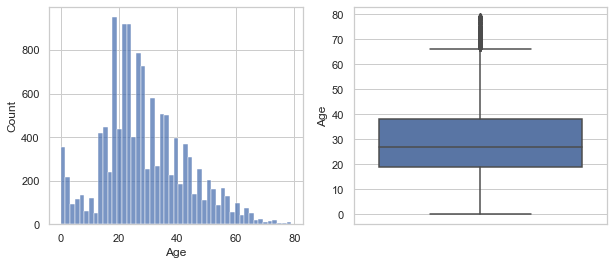

In [18]:
#Exploring numerical features ('Age')
fig, a=plt.subplots(1,2,figsize=(10,4));
sns.histplot(df32['Age'],ax=a[0]);
sns.boxplot(y=df32['Age'],ax=a[1]);

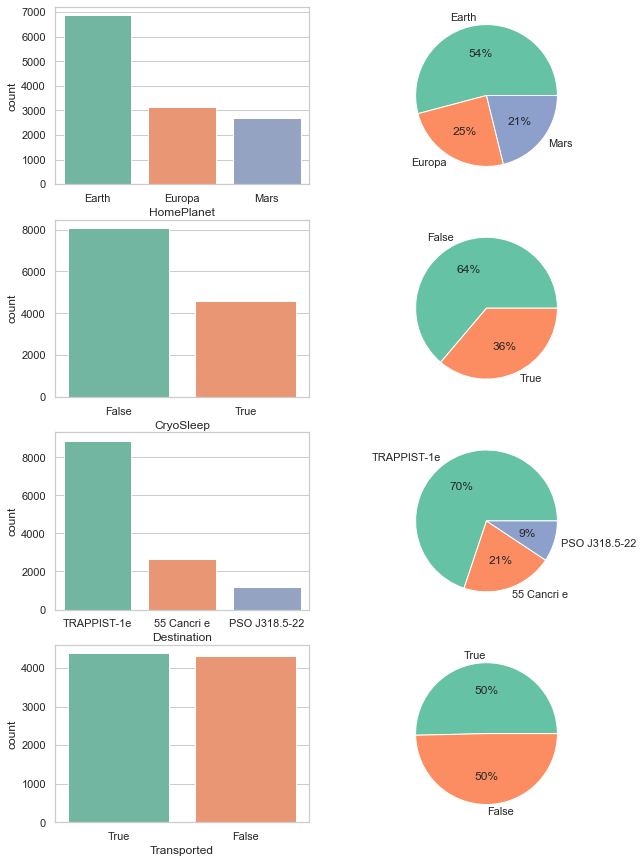

In [19]:
m_describe.visualize_cat(df32,figure_size=(10,15))

# ----NEW CODES----

In [244]:
#extracting train and test data back

df12=df33.iloc[:8693,:]
df22=df33.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [245]:
df1.shape,df12.shape

((8693, 14), (8693, 5))

In [246]:
df2.shape,df22.shape

((4277, 13), (4277, 4))

In [247]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [248]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [249]:
model = LazyClassifier()

In [251]:
model.fit(xtr_sc,xts_sc,ytr,yts)

100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

[LightGBM] [Info] Number of positive: 3506, number of negative: 3448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504170 -> initscore=0.016681
[LightGBM] [Info] Start training from score 0.016681


(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 SVC                                0.61               0.61     0.61      0.60   
 AdaBoostClassifier                 0.61               0.61     0.61      0.60   
 GaussianNB                         0.60               0.61     0.61      0.60   
 LabelSpreading                     0.60               0.61     0.61      0.60   
 LabelPropagation                   0.60               0.61     0.61      0.60   
 LogisticRegression                 0.60               0.60     0.60      0.60   
 RidgeClassifierCV                  0.60               0.60     0.60      0.59   
 RidgeClassifier                    0.60               0.60     0.60      0.59   
 LinearDiscriminantAnalysis         0.60               0.60     0.60      0.59   
 LinearSVC                          0.60               0.60     0.60      0.59   
 QuadraticDiscri

In [232]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3488, number of negative: 3466
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501582 -> initscore=0.006327
[LightGBM] [Info] Start training from score 0.006327
Learning rate set to 0.023581
0:	learn: 0.6905034	total: 4.4ms	remaining: 4.4s
1:	learn: 0.6880933	total: 8.81ms	remaining: 4.4s
2:	learn: 0.6860000	total: 13.2ms	remaining: 4.39s
3:	learn: 0.6847630	total: 17.3ms	remaining: 4.32s
4:	learn: 0.6828924	total: 22ms	remaining: 4.38s
5:	learn: 0.6809938	total: 26.4ms	remaining: 4.38s
6:	learn: 0.6793669	total: 30.8ms	re

166:	learn: 0.6443216	total: 762ms	remaining: 3.8s
167:	learn: 0.6443094	total: 766ms	remaining: 3.79s
168:	learn: 0.6442846	total: 771ms	remaining: 3.79s
169:	learn: 0.6442297	total: 776ms	remaining: 3.79s
170:	learn: 0.6442131	total: 780ms	remaining: 3.78s
171:	learn: 0.6441863	total: 784ms	remaining: 3.78s
172:	learn: 0.6441458	total: 789ms	remaining: 3.77s
173:	learn: 0.6441227	total: 797ms	remaining: 3.78s
174:	learn: 0.6441039	total: 802ms	remaining: 3.78s
175:	learn: 0.6440506	total: 808ms	remaining: 3.78s
176:	learn: 0.6440103	total: 813ms	remaining: 3.78s
177:	learn: 0.6438874	total: 817ms	remaining: 3.77s
178:	learn: 0.6438829	total: 821ms	remaining: 3.76s
179:	learn: 0.6438478	total: 825ms	remaining: 3.76s
180:	learn: 0.6438421	total: 828ms	remaining: 3.75s
181:	learn: 0.6437522	total: 832ms	remaining: 3.74s
182:	learn: 0.6437391	total: 837ms	remaining: 3.73s
183:	learn: 0.6436964	total: 841ms	remaining: 3.73s
184:	learn: 0.6436461	total: 845ms	remaining: 3.72s
185:	learn: 0

327:	learn: 0.6404651	total: 1.47s	remaining: 3.01s
328:	learn: 0.6404635	total: 1.47s	remaining: 3s
329:	learn: 0.6404475	total: 1.48s	remaining: 3s
330:	learn: 0.6404173	total: 1.48s	remaining: 2.99s
331:	learn: 0.6404112	total: 1.49s	remaining: 2.99s
332:	learn: 0.6404095	total: 1.49s	remaining: 2.98s
333:	learn: 0.6403776	total: 1.5s	remaining: 2.98s
334:	learn: 0.6403697	total: 1.5s	remaining: 2.98s
335:	learn: 0.6403627	total: 1.5s	remaining: 2.97s
336:	learn: 0.6403531	total: 1.51s	remaining: 2.98s
337:	learn: 0.6403523	total: 1.52s	remaining: 2.97s
338:	learn: 0.6403517	total: 1.52s	remaining: 2.96s
339:	learn: 0.6403286	total: 1.53s	remaining: 2.96s
340:	learn: 0.6403063	total: 1.53s	remaining: 2.96s
341:	learn: 0.6402804	total: 1.54s	remaining: 2.96s
342:	learn: 0.6402796	total: 1.54s	remaining: 2.95s
343:	learn: 0.6402708	total: 1.54s	remaining: 2.95s
344:	learn: 0.6402497	total: 1.55s	remaining: 2.94s
345:	learn: 0.6402220	total: 1.55s	remaining: 2.94s
346:	learn: 0.6401862

497:	learn: 0.6364257	total: 2.34s	remaining: 2.36s
498:	learn: 0.6363849	total: 2.35s	remaining: 2.36s
499:	learn: 0.6363555	total: 2.36s	remaining: 2.36s
500:	learn: 0.6363314	total: 2.37s	remaining: 2.36s
501:	learn: 0.6363074	total: 2.38s	remaining: 2.36s
502:	learn: 0.6362669	total: 2.38s	remaining: 2.36s
503:	learn: 0.6362616	total: 2.39s	remaining: 2.35s
504:	learn: 0.6362243	total: 2.4s	remaining: 2.35s
505:	learn: 0.6361831	total: 2.41s	remaining: 2.35s
506:	learn: 0.6361640	total: 2.42s	remaining: 2.35s
507:	learn: 0.6361454	total: 2.42s	remaining: 2.35s
508:	learn: 0.6361017	total: 2.43s	remaining: 2.35s
509:	learn: 0.6360726	total: 2.44s	remaining: 2.35s
510:	learn: 0.6360418	total: 2.45s	remaining: 2.34s
511:	learn: 0.6360056	total: 2.46s	remaining: 2.34s
512:	learn: 0.6359636	total: 2.46s	remaining: 2.33s
513:	learn: 0.6359487	total: 2.46s	remaining: 2.33s
514:	learn: 0.6359295	total: 2.47s	remaining: 2.33s
515:	learn: 0.6359048	total: 2.48s	remaining: 2.32s
516:	learn: 0

656:	learn: 0.6328502	total: 3.22s	remaining: 1.68s
657:	learn: 0.6328146	total: 3.22s	remaining: 1.67s
658:	learn: 0.6328091	total: 3.23s	remaining: 1.67s
659:	learn: 0.6327862	total: 3.23s	remaining: 1.67s
660:	learn: 0.6327482	total: 3.24s	remaining: 1.66s
661:	learn: 0.6327069	total: 3.25s	remaining: 1.66s
662:	learn: 0.6326842	total: 3.26s	remaining: 1.66s
663:	learn: 0.6326542	total: 3.27s	remaining: 1.65s
664:	learn: 0.6326102	total: 3.27s	remaining: 1.65s
665:	learn: 0.6325861	total: 3.28s	remaining: 1.64s
666:	learn: 0.6325716	total: 3.29s	remaining: 1.64s
667:	learn: 0.6325566	total: 3.29s	remaining: 1.64s
668:	learn: 0.6325115	total: 3.3s	remaining: 1.63s
669:	learn: 0.6325016	total: 3.31s	remaining: 1.63s
670:	learn: 0.6324888	total: 3.31s	remaining: 1.63s
671:	learn: 0.6324709	total: 3.32s	remaining: 1.62s
672:	learn: 0.6324542	total: 3.33s	remaining: 1.62s
673:	learn: 0.6324186	total: 3.33s	remaining: 1.61s
674:	learn: 0.6324007	total: 3.34s	remaining: 1.61s
675:	learn: 0

815:	learn: 0.6299282	total: 4.25s	remaining: 958ms
816:	learn: 0.6299044	total: 4.25s	remaining: 953ms
817:	learn: 0.6298981	total: 4.26s	remaining: 948ms
818:	learn: 0.6298757	total: 4.27s	remaining: 943ms
819:	learn: 0.6298705	total: 4.27s	remaining: 938ms
820:	learn: 0.6298511	total: 4.29s	remaining: 934ms
821:	learn: 0.6298365	total: 4.29s	remaining: 929ms
822:	learn: 0.6298113	total: 4.3s	remaining: 924ms
823:	learn: 0.6297944	total: 4.3s	remaining: 919ms
824:	learn: 0.6297731	total: 4.31s	remaining: 915ms
825:	learn: 0.6297420	total: 4.32s	remaining: 910ms
826:	learn: 0.6297191	total: 4.33s	remaining: 905ms
827:	learn: 0.6296990	total: 4.33s	remaining: 900ms
828:	learn: 0.6296896	total: 4.34s	remaining: 895ms
829:	learn: 0.6296766	total: 4.35s	remaining: 891ms
830:	learn: 0.6296646	total: 4.35s	remaining: 885ms
831:	learn: 0.6296354	total: 4.36s	remaining: 881ms
832:	learn: 0.6296310	total: 4.37s	remaining: 876ms
833:	learn: 0.6296155	total: 4.37s	remaining: 871ms
834:	learn: 0.

989:	learn: 0.6274683	total: 5.49s	remaining: 55.5ms
990:	learn: 0.6274611	total: 5.5s	remaining: 49.9ms
991:	learn: 0.6274479	total: 5.5s	remaining: 44.4ms
992:	learn: 0.6274439	total: 5.51s	remaining: 38.8ms
993:	learn: 0.6274413	total: 5.51s	remaining: 33.3ms
994:	learn: 0.6274377	total: 5.52s	remaining: 27.7ms
995:	learn: 0.6274257	total: 5.53s	remaining: 22.2ms
996:	learn: 0.6274185	total: 5.54s	remaining: 16.7ms
997:	learn: 0.6273989	total: 5.54s	remaining: 11.1ms
998:	learn: 0.6273837	total: 5.55s	remaining: 5.56ms
999:	learn: 0.6273677	total: 5.56s	remaining: 0us


,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.607246
1,8,CatBoost Classifier,General,Yes,0.603220
2,0,Logistic,General,Yes,0.594020
3,7,LGBM Classifier,General,Yes,0.590569
4,6,XGB Classifier,General,Yes,0.588844
5,2,GaussianNB,General,Yes,0.587119
6,5,RandomForest,General,Yes,0.583094
7,4,DecisionTree,General,Yes,0.580794
8,1,Kneighbors,General,Yes,0.569293


# Handling missing values

In [20]:
m_describe.missing_val_list(df32)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,270,2.0
1,HomePlanet,Categorical,288,2.0
2,CryoSleep,Categorical,310,2.0
3,Destination,Categorical,274,2.0
4,Transported,Categorical,4277,33.0


In [21]:
df33=df32.copy()

In [22]:
df33['Age'].fillna(df3['Age'].median(),inplace=True)
df33['HomePlanet'].fillna(df33['HomePlanet'].mode()[0],inplace=True)
df33['CryoSleep'].fillna(df33['CryoSleep'].mode()[0],inplace=True)
df33['Destination'].fillna(df33['Destination'].mode()[0],inplace=True)

# Modelling raw data

In [23]:
#extracting train and test data back

df12=df33.iloc[:8693,:]
df22=df33.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [24]:
df1.shape,df12.shape

((8693, 14), (8693, 5))

In [25]:
df2.shape,df22.shape

((4277, 13), (4277, 4))

In [26]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [27]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [28]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,2,GaussianNB,General,Yes,0.617021
1,3,SVC,General,Yes,0.617021
2,4,DecisionTree,General,Yes,0.608396
3,0,Logistic,General,Yes,0.607821
4,5,RandomForest,General,Yes,0.606095
5,1,Kneighbors,General,Yes,0.576193


so best model so far is SVC

# Feature Engineering / Selection

## Spending features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck]

### Handling outliers

In [29]:
df35=df31.copy()

In [30]:
#filling missing values by median
#numerical
x=['Age','RoomService','FoodCourt','ShoppingMall', 'Spa', 'VRDeck']
for i in range(len(x)):
    df35[x[i]].fillna(df35[x[i]].median(),inplace=True)

#categorical
x=['HomePlanet','CryoSleep','Destination']
for i in range(len(x)):
    df35[x[i]].fillna(df35[x[i]].mode()[0],inplace=True)

In [31]:
df15=df35.iloc[:8693,:]
features=df15.columns

In [32]:
num=m_describe.num(df15)
print (num)
m_outlier_all(df15,n=0,features=num)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Method IQR:
Total number of outliers is: 1849
Total number of observations containing more than 0 outliers is: 5058 
Percentage of data to be lost is: %58.0

Method Standard deviation:
Total number of outliers is: 166
Total number of observations containing more than 0 outliers is: 756 
Percentage of data to be lost is: %9.0

Method Z-Score:
Total number of outliers is: 166
Total number of observations containing more than 0 outliers is: 756 
Percentage of data to be lost is: %9.0

Method Modified Z-Score:
Total number of outliers is: 8693
Total number of observations containing more than 0 outliers is: 8693 
Percentage of data to be lost is: %100.0

Method Isolation forest:
The total number of outliers is:  580
Percentage of data to be lost is: %7.0

Method DBSCAN:
The total number of clusters without outliers:  9
The number of outliers is:  981
Percentage of data to be lost is: %11.0
--------------------------------

{2,
 11,
 30,
 54,
 70,
 73,
 75,
 105,
 113,
 120,
 154,
 224,
 230,
 232,
 268,
 275,
 280,
 301,
 316,
 326,
 335,
 336,
 338,
 358,
 359,
 362,
 375,
 379,
 385,
 387,
 439,
 453,
 474,
 490,
 495,
 496,
 503,
 582,
 636,
 637,
 666,
 707,
 725,
 735,
 764,
 799,
 832,
 844,
 848,
 857,
 871,
 926,
 928,
 930,
 936,
 983,
 1043,
 1053,
 1057,
 1073,
 1078,
 1094,
 1095,
 1098,
 1133,
 1136,
 1171,
 1177,
 1186,
 1213,
 1222,
 1233,
 1237,
 1341,
 1347,
 1381,
 1385,
 1390,
 1391,
 1436,
 1447,
 1451,
 1459,
 1467,
 1496,
 1562,
 1572,
 1579,
 1595,
 1598,
 1603,
 1666,
 1667,
 1679,
 1701,
 1703,
 1720,
 1725,
 1740,
 1770,
 1782,
 1783,
 1831,
 1842,
 1886,
 1913,
 1938,
 1945,
 1947,
 1958,
 1968,
 1980,
 2031,
 2036,
 2050,
 2067,
 2097,
 2127,
 2130,
 2137,
 2142,
 2143,
 2147,
 2153,
 2158,
 2163,
 2182,
 2207,
 2214,
 2245,
 2310,
 2324,
 2331,
 2334,
 2340,
 2364,
 2406,
 2415,
 2464,
 2468,
 2492,
 2493,
 2499,
 2537,
 2552,
 2604,
 2607,
 2618,
 2647,
 2687,
 2734,
 2757,


In [33]:
drop_index=_
df16=df15.copy()
df16.drop(labels=drop_index,axis=0,inplace=True)
df15.shape,df16.shape

((8693, 10), (8219, 10))

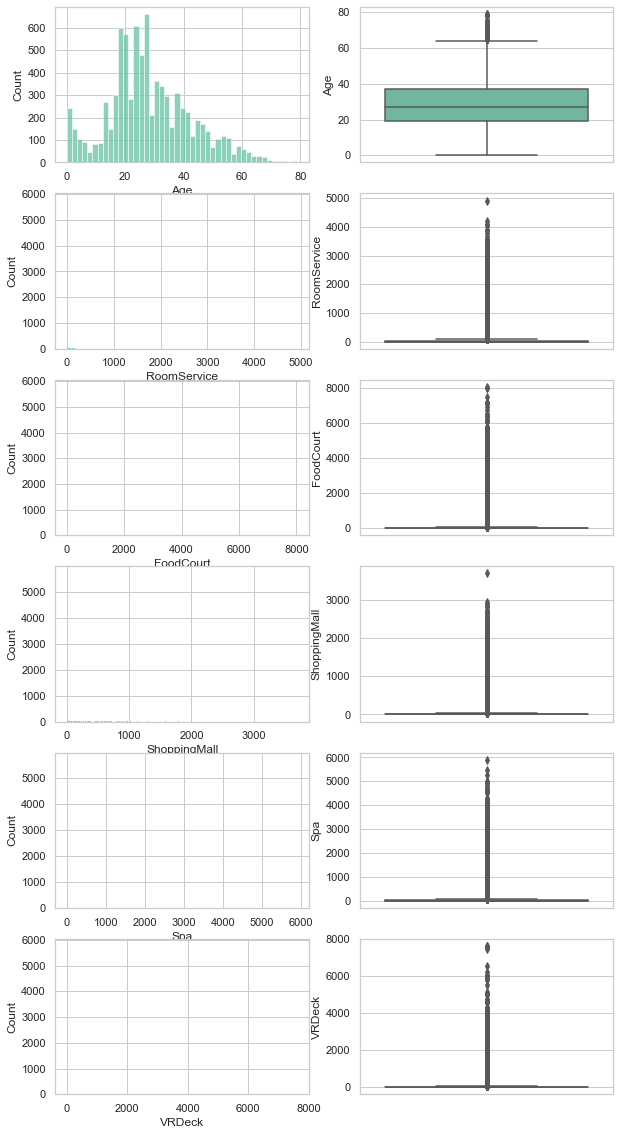

In [34]:
m_describe.visualize_num(df16,features=num,figure_size=(10,20))

In [35]:
m_outlier_all(df16,n=0,features=['RoomService'])

Method IQR:
Total number of outliers is: 1812
Total number of observations containing more than 0 outliers is: 1812 
Percentage of data to be lost is: %22.0

Method Standard deviation:
Total number of outliers is: 231
Total number of observations containing more than 0 outliers is: 231 
Percentage of data to be lost is: %3.0

Method Z-Score:
Total number of outliers is: 231
Total number of observations containing more than 0 outliers is: 231 
Percentage of data to be lost is: %3.0

Method Modified Z-Score:
Total number of outliers is: 8219
Total number of observations containing more than 0 outliers is: 8219 
Percentage of data to be lost is: %100.0

Method Isolation forest:
The total number of outliers is:  2256
Percentage of data to be lost is: %27.0

Method DBSCAN:
The total number of clusters without outliers:  1
The number of outliers is:  1
Percentage of data to be lost is: %0.0
----------------------------------------------------------------------------------------------------
T

set()

In [36]:
m_outlier_std(df16,n=0,features=['RoomService'])

Total number of outliers is: 231
Total number of observations containing more than 0 outliers is: 231 
Percentage of data to be lost is: %3.0


[63,
 99,
 121,
 124,
 140,
 155,
 203,
 205,
 231,
 239,
 364,
 404,
 405,
 425,
 464,
 533,
 544,
 559,
 620,
 657,
 658,
 659,
 670,
 680,
 827,
 847,
 949,
 1027,
 1105,
 1115,
 1193,
 1212,
 1240,
 1244,
 1316,
 1325,
 1424,
 1559,
 1574,
 1609,
 1611,
 1659,
 1708,
 1727,
 1729,
 1751,
 1769,
 1798,
 1808,
 1816,
 1826,
 1845,
 1959,
 1960,
 1964,
 2016,
 2045,
 2057,
 2058,
 2089,
 2113,
 2228,
 2307,
 2348,
 2366,
 2388,
 2443,
 2456,
 2482,
 2486,
 2511,
 2550,
 2591,
 2673,
 2683,
 2752,
 2795,
 2820,
 2832,
 2842,
 2864,
 2880,
 2931,
 2994,
 3020,
 3051,
 3090,
 3125,
 3170,
 3288,
 3316,
 3446,
 3467,
 3548,
 3588,
 3607,
 3663,
 3669,
 3710,
 3747,
 3764,
 3801,
 3815,
 3817,
 3932,
 3974,
 4064,
 4193,
 4202,
 4208,
 4422,
 4430,
 4488,
 4552,
 4565,
 4609,
 4632,
 4657,
 4669,
 4747,
 4764,
 4875,
 4897,
 4961,
 4974,
 5011,
 5037,
 5041,
 5056,
 5057,
 5082,
 5119,
 5150,
 5212,
 5285,
 5287,
 5321,
 5365,
 5457,
 5590,
 5617,
 5633,
 5701,
 5706,
 5717,
 5730,
 5812,


In [37]:
drop_index=_
df16=df15.copy()
df16.drop(labels=drop_index,axis=0,inplace=True)
df15.shape,df16.shape

((8693, 10), (8462, 10))

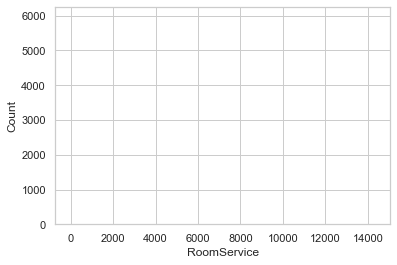

In [38]:
sns.histplot(df16['RoomService']);

In [39]:
print (df15[(df15['RoomService']==0)]['RoomService'].count()/df15.shape[0]*100)
print (df15[(df15['FoodCourt']==0)]['FoodCourt'].count()/df15.shape[0]*100)
print (df15[(df15['ShoppingMall']==0)]['ShoppingMall'].count()/df15.shape[0]*100)
print (df15[(df15['Spa']==0)]['Spa'].count()/df15.shape[0]*100)
print (df15[(df15['VRDeck']==0)]['VRDeck'].count()/df15.shape[0]*100)

66.23720234671575
64.86828482687218
66.66283216380997
63.34982169561716
65.3744392039572


**Interesting fact, >64% of all passengers didn't spend money on spaceship, we can classify them into two categories by spend and not spend**

### Labeling

In [40]:
df36=df35.copy()

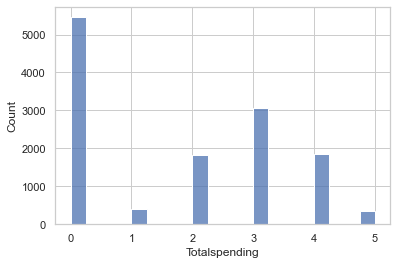

In [41]:
#classifying spending columns to be 1 if more than 0 and 0 of spending is 0
df36['RoomService']= df36['RoomService'].map(lambda x: 1 if x>0 else 0)
df36['FoodCourt']= df36['FoodCourt'].map(lambda x: 1 if x>0 else 0)
df36['ShoppingMall']= df36['ShoppingMall'].map(lambda x: 1 if x>0 else 0)
df36['Spa']= df36['Spa'].map(lambda x: 1 if x>0 else 0)
df36['VRDeck']= df36['VRDeck'].map(lambda x: 1 if x>0 else 0)
#exploring if there are passengers can spend on some features and not on any other features
df36['Totalspending']=df36['RoomService']+df36['FoodCourt']+df36['ShoppingMall']+df36['Spa']+df36['VRDeck']
sns.histplot(df36['Totalspending']);

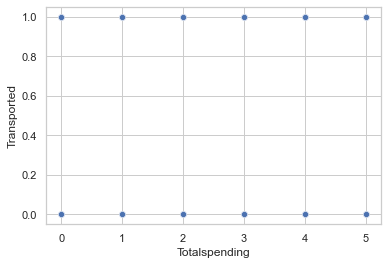

In [42]:
sns.scatterplot(df36['Totalspending'],df36['Transported']);

### Remodelling

In [43]:
#extracting train and test data back

df12=df36.iloc[:8693,:]
df22=df36.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [44]:
df1.shape,df12.shape

((8693, 14), (8693, 11))

In [45]:
df2.shape,df22.shape

((4277, 13), (4277, 10))

In [46]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [47]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [48]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.743531
1,0,Logistic,General,Yes,0.727430
2,2,GaussianNB,General,Yes,0.723404
3,1,Kneighbors,General,Yes,0.709603
4,4,DecisionTree,General,Yes,0.691202
5,5,RandomForest,General,Yes,0.684301


Wow, my model improved very much by including spending features

## PassengerId


### Extracting new features

In [49]:
df3[['PassengerId','Cabin','VIP']].head(5)

,PassengerId,Cabin,VIP
0,0001_01,B/0/P,False
1,0002_01,F/0/S,False
2,0003_01,A/0/S,True
3,0003_02,A/0/S,False
4,0004_01,F/1/S,False


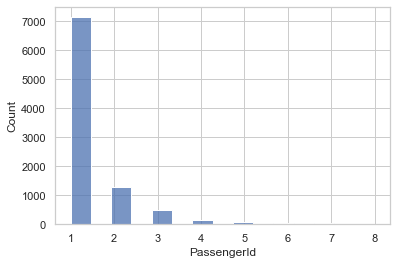

In [50]:
#PassengerId
sns.histplot(df3['PassengerId'].str[0:4].value_counts());

In [51]:
df37=df36.copy()

In [52]:
df3['PassengerId'].str[0:4].head(5)

0    0001
1    0002
2    0003
3    0003
4    0004
Name: PassengerId, dtype: object

In [53]:
df37['HasFamily']=df3['PassengerId'].str[0:4]

In [54]:
value_counts = df37['HasFamily'].value_counts().to_dict()
# replace the values in column 'A' with their counts
df37['HasFamily'] = df37['HasFamily'].map(value_counts)
df37['HasFamily'] = df37['HasFamily'].map(lambda x: 1 if x>1 else 0)

### Remodelling

In [55]:
#extracting train and test data back

df12=df37.iloc[:8693,:]
df22=df37.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [56]:
df1.shape,df12.shape

((8693, 14), (8693, 12))

In [57]:
df2.shape,df22.shape

((4277, 13), (4277, 11))

In [58]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [59]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [60]:
cat

['HomePlanet',
 'Destination',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'HasFamily']

In [61]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [62]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.740081
1,0,Logistic,General,Yes,0.734330
2,2,GaussianNB,General,Yes,0.721104
3,1,Kneighbors,General,Yes,0.706728
4,5,RandomForest,General,Yes,0.697527
5,4,DecisionTree,General,Yes,0.677976


it didn't improve very much considering if passenger has family or not in Titan spaceship

## Cabin

### Extracting new features

In [63]:
#Cabin
x = pd.DataFrame()
x['Deck']=df3['Cabin'].str[0]
x['Num']=df3['Cabin'].str.extract(r'/(.+?)/')
x['Side']=df3['Cabin'].str[-1]

In [64]:
print (x['Deck'].nunique()) ,print (x['Deck'].value_counts())
print (x['Num'].nunique()) ,print (x['Num'].value_counts())
print (x['Side'].nunique()) ,print (x['Side'].value_counts())

8
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64
1894
82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: Num, Length: 1894, dtype: int64
2
S    6381
P    6290
Name: Side, dtype: int64


(None, None)

Based on the number of unique values of Deck, Number and side, I guess the most important feauters are Deck and Side

In [65]:
df38=df37.copy()

In [66]:
df38['Deck']=x['Deck']
df38['Side']=x['Side']
df38.head(5)

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Totalspending,HasFamily,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,0,0,0,0,0,False,0,0,B,P
1,Earth,False,TRAPPIST-1e,24.0,1,1,1,1,1,True,5,0,F,S
2,Europa,False,TRAPPIST-1e,58.0,1,1,0,1,1,False,4,1,A,S
3,Europa,False,TRAPPIST-1e,33.0,0,1,1,1,1,False,4,1,A,S
4,Earth,False,TRAPPIST-1e,16.0,1,1,1,1,1,True,5,0,F,S


In [67]:
m_describe.missing_val_list(df38)

,Feature,Type,count of nulls,null % of total obesrvations
0,Transported,Categorical,4277,33.0
1,Deck,Categorical,299,2.0
2,Side,Categorical,299,2.0


Let's fill missing values in Deck and Side

In [68]:
df38['Deck'].fillna(df38['Deck'].mode()[0],inplace=True)
df38['Side'].fillna(df38['Side'].mode()[0],inplace=True)

### Remodelling

In [69]:
#extracting train and test data back

df12=df38.iloc[:8693,:]
df22=df38.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [70]:
df1.shape,df12.shape

((8693, 14), (8693, 14))

In [71]:
df2.shape,df22.shape

((4277, 13), (4277, 13))

In [72]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [73]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [74]:
num

['Age', 'Totalspending']

In [75]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [76]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.744681
1,0,Logistic,General,Yes,0.725129
2,1,Kneighbors,General,Yes,0.721679
3,2,GaussianNB,General,Yes,0.705578
4,5,RandomForest,General,Yes,0.705003
5,4,DecisionTree,General,Yes,0.672225


Adding cabin feautes, didn't improve our model accuracy

## VIP

### Feature engineering

In [77]:
#VIP
df39 = df37.copy()

In [78]:
df39['VIP']=df3['VIP']

In [79]:
#filling missing values
df39['VIP'].isnull().sum()

296

In [80]:
df39['VIP'].fillna(df39['VIP'].mode()[0],inplace=True)

### Remodelling

In [253]:
#extracting train and test data back

df12=df39.iloc[:8693,:]
df22=df39.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [254]:
df1.shape,df12.shape

((8693, 14), (8693, 13))

In [255]:
df2.shape,df22.shape

((4277, 13), (4277, 12))

In [256]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [259]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [262]:
model=CatBoostClassifier(iterations=1500,eval_metric='Accuracy')

In [263]:
model.fit(xtr_sc,ytr)

Learning rate set to 0.016259
0:	learn: 0.7391429	total: 29.1ms	remaining: 43.6s
1:	learn: 0.7389991	total: 34.3ms	remaining: 25.7s
2:	learn: 0.7381363	total: 39.5ms	remaining: 19.7s
3:	learn: 0.7382801	total: 45.4ms	remaining: 17s
4:	learn: 0.7381363	total: 50.7ms	remaining: 15.2s
5:	learn: 0.7382801	total: 56.5ms	remaining: 14.1s
6:	learn: 0.7379925	total: 61.8ms	remaining: 13.2s
7:	learn: 0.7381363	total: 67.1ms	remaining: 12.5s
8:	learn: 0.7381363	total: 73ms	remaining: 12.1s
9:	learn: 0.7381363	total: 78.2ms	remaining: 11.7s
10:	learn: 0.7381363	total: 83.5ms	remaining: 11.3s
11:	learn: 0.7381363	total: 87.8ms	remaining: 10.9s
12:	learn: 0.7381363	total: 93.1ms	remaining: 10.6s
13:	learn: 0.7381363	total: 98.5ms	remaining: 10.4s
14:	learn: 0.7381363	total: 104ms	remaining: 10.3s
15:	learn: 0.7381363	total: 108ms	remaining: 10s
16:	learn: 0.7381363	total: 113ms	remaining: 9.85s
17:	learn: 0.7381363	total: 117ms	remaining: 9.63s
18:	learn: 0.7381363	total: 121ms	remaining: 9.4s
19:	

172:	learn: 0.7474835	total: 1.02s	remaining: 7.82s
173:	learn: 0.7471959	total: 1.02s	remaining: 7.81s
174:	learn: 0.7474835	total: 1.03s	remaining: 7.82s
175:	learn: 0.7476273	total: 1.04s	remaining: 7.82s
176:	learn: 0.7477711	total: 1.04s	remaining: 7.82s
177:	learn: 0.7479149	total: 1.05s	remaining: 7.82s
178:	learn: 0.7479149	total: 1.06s	remaining: 7.81s
179:	learn: 0.7480587	total: 1.06s	remaining: 7.81s
180:	learn: 0.7480587	total: 1.07s	remaining: 7.8s
181:	learn: 0.7480587	total: 1.07s	remaining: 7.79s
182:	learn: 0.7480587	total: 1.08s	remaining: 7.78s
183:	learn: 0.7482025	total: 1.09s	remaining: 7.79s
184:	learn: 0.7482025	total: 1.1s	remaining: 7.8s
185:	learn: 0.7482025	total: 1.1s	remaining: 7.79s
186:	learn: 0.7480587	total: 1.11s	remaining: 7.78s
187:	learn: 0.7479149	total: 1.11s	remaining: 7.77s
188:	learn: 0.7479149	total: 1.12s	remaining: 7.76s
189:	learn: 0.7483463	total: 1.12s	remaining: 7.75s
190:	learn: 0.7483463	total: 1.13s	remaining: 7.74s
191:	learn: 0.74

347:	learn: 0.7513661	total: 2.08s	remaining: 6.9s
348:	learn: 0.7515099	total: 2.09s	remaining: 6.9s
349:	learn: 0.7515099	total: 2.1s	remaining: 6.89s
350:	learn: 0.7515099	total: 2.1s	remaining: 6.89s
351:	learn: 0.7515099	total: 2.11s	remaining: 6.89s
352:	learn: 0.7515099	total: 2.12s	remaining: 6.89s
353:	learn: 0.7516537	total: 2.13s	remaining: 6.88s
354:	learn: 0.7516537	total: 2.14s	remaining: 6.89s
355:	learn: 0.7515099	total: 2.14s	remaining: 6.89s
356:	learn: 0.7515099	total: 2.16s	remaining: 6.91s
357:	learn: 0.7515099	total: 2.16s	remaining: 6.9s
358:	learn: 0.7515099	total: 2.17s	remaining: 6.9s
359:	learn: 0.7515099	total: 2.18s	remaining: 6.9s
360:	learn: 0.7516537	total: 2.18s	remaining: 6.89s
361:	learn: 0.7516537	total: 2.19s	remaining: 6.88s
362:	learn: 0.7516537	total: 2.19s	remaining: 6.87s
363:	learn: 0.7516537	total: 2.2s	remaining: 6.87s
364:	learn: 0.7516537	total: 2.21s	remaining: 6.86s
365:	learn: 0.7516537	total: 2.21s	remaining: 6.85s
366:	learn: 0.751653

525:	learn: 0.7551050	total: 3.15s	remaining: 5.84s
526:	learn: 0.7551050	total: 3.16s	remaining: 5.83s
527:	learn: 0.7551050	total: 3.17s	remaining: 5.83s
528:	learn: 0.7551050	total: 3.17s	remaining: 5.83s
529:	learn: 0.7551050	total: 3.18s	remaining: 5.82s
530:	learn: 0.7551050	total: 3.19s	remaining: 5.82s
531:	learn: 0.7552488	total: 3.2s	remaining: 5.82s
532:	learn: 0.7552488	total: 3.2s	remaining: 5.81s
533:	learn: 0.7552488	total: 3.21s	remaining: 5.8s
534:	learn: 0.7552488	total: 3.22s	remaining: 5.8s
535:	learn: 0.7552488	total: 3.22s	remaining: 5.79s
536:	learn: 0.7552488	total: 3.23s	remaining: 5.79s
537:	learn: 0.7553926	total: 3.23s	remaining: 5.78s
538:	learn: 0.7553926	total: 3.24s	remaining: 5.78s
539:	learn: 0.7552488	total: 3.25s	remaining: 5.77s
540:	learn: 0.7552488	total: 3.25s	remaining: 5.76s
541:	learn: 0.7552488	total: 3.26s	remaining: 5.75s
542:	learn: 0.7553926	total: 3.26s	remaining: 5.75s
543:	learn: 0.7553926	total: 3.27s	remaining: 5.74s
544:	learn: 0.75

689:	learn: 0.7608571	total: 4.23s	remaining: 4.96s
690:	learn: 0.7608571	total: 4.24s	remaining: 4.96s
691:	learn: 0.7608571	total: 4.24s	remaining: 4.95s
692:	learn: 0.7608571	total: 4.25s	remaining: 4.95s
693:	learn: 0.7608571	total: 4.26s	remaining: 4.95s
694:	learn: 0.7608571	total: 4.27s	remaining: 4.94s
695:	learn: 0.7608571	total: 4.27s	remaining: 4.94s
696:	learn: 0.7608571	total: 4.28s	remaining: 4.94s
697:	learn: 0.7608571	total: 4.29s	remaining: 4.93s
698:	learn: 0.7608571	total: 4.3s	remaining: 4.93s
699:	learn: 0.7608571	total: 4.3s	remaining: 4.92s
700:	learn: 0.7608571	total: 4.31s	remaining: 4.92s
701:	learn: 0.7608571	total: 4.32s	remaining: 4.91s
702:	learn: 0.7608571	total: 4.33s	remaining: 4.9s
703:	learn: 0.7608571	total: 4.33s	remaining: 4.9s
704:	learn: 0.7610009	total: 4.34s	remaining: 4.89s
705:	learn: 0.7611447	total: 4.34s	remaining: 4.88s
706:	learn: 0.7611447	total: 4.35s	remaining: 4.88s
707:	learn: 0.7614323	total: 4.35s	remaining: 4.87s
708:	learn: 0.76

851:	learn: 0.7658901	total: 5.31s	remaining: 4.04s
852:	learn: 0.7658901	total: 5.33s	remaining: 4.04s
853:	learn: 0.7658901	total: 5.34s	remaining: 4.04s
854:	learn: 0.7658901	total: 5.35s	remaining: 4.04s
855:	learn: 0.7658901	total: 5.37s	remaining: 4.04s
856:	learn: 0.7658901	total: 5.39s	remaining: 4.04s
857:	learn: 0.7658901	total: 5.4s	remaining: 4.04s
858:	learn: 0.7660339	total: 5.42s	remaining: 4.04s
859:	learn: 0.7660339	total: 5.43s	remaining: 4.04s
860:	learn: 0.7660339	total: 5.44s	remaining: 4.04s
861:	learn: 0.7660339	total: 5.45s	remaining: 4.03s
862:	learn: 0.7660339	total: 5.46s	remaining: 4.03s
863:	learn: 0.7658901	total: 5.48s	remaining: 4.03s
864:	learn: 0.7658901	total: 5.5s	remaining: 4.03s
865:	learn: 0.7661777	total: 5.51s	remaining: 4.03s
866:	learn: 0.7661777	total: 5.52s	remaining: 4.03s
867:	learn: 0.7661777	total: 5.53s	remaining: 4.02s
868:	learn: 0.7661777	total: 5.54s	remaining: 4.02s
869:	learn: 0.7663215	total: 5.55s	remaining: 4.02s
870:	learn: 0.

1035:	learn: 0.7689100	total: 6.58s	remaining: 2.95s
1036:	learn: 0.7690538	total: 6.58s	remaining: 2.94s
1037:	learn: 0.7690538	total: 6.59s	remaining: 2.93s
1038:	learn: 0.7689100	total: 6.59s	remaining: 2.93s
1039:	learn: 0.7689100	total: 6.6s	remaining: 2.92s
1040:	learn: 0.7690538	total: 6.61s	remaining: 2.92s
1041:	learn: 0.7690538	total: 6.62s	remaining: 2.91s
1042:	learn: 0.7690538	total: 6.63s	remaining: 2.9s
1043:	learn: 0.7689100	total: 6.64s	remaining: 2.9s
1044:	learn: 0.7690538	total: 6.66s	remaining: 2.9s
1045:	learn: 0.7690538	total: 6.66s	remaining: 2.89s
1046:	learn: 0.7690538	total: 6.67s	remaining: 2.88s
1047:	learn: 0.7691976	total: 6.67s	remaining: 2.88s
1048:	learn: 0.7693414	total: 6.68s	remaining: 2.87s
1049:	learn: 0.7693414	total: 6.69s	remaining: 2.87s
1050:	learn: 0.7693414	total: 6.69s	remaining: 2.86s
1051:	learn: 0.7693414	total: 6.7s	remaining: 2.85s
1052:	learn: 0.7693414	total: 6.71s	remaining: 2.85s
1053:	learn: 0.7693414	total: 6.71s	remaining: 2.84

1216:	learn: 0.7730802	total: 7.65s	remaining: 1.78s
1217:	learn: 0.7730802	total: 7.66s	remaining: 1.77s
1218:	learn: 0.7730802	total: 7.66s	remaining: 1.77s
1219:	learn: 0.7730802	total: 7.67s	remaining: 1.76s
1220:	learn: 0.7730802	total: 7.68s	remaining: 1.75s
1221:	learn: 0.7732240	total: 7.68s	remaining: 1.75s
1222:	learn: 0.7732240	total: 7.69s	remaining: 1.74s
1223:	learn: 0.7732240	total: 7.7s	remaining: 1.74s
1224:	learn: 0.7732240	total: 7.7s	remaining: 1.73s
1225:	learn: 0.7733678	total: 7.71s	remaining: 1.72s
1226:	learn: 0.7730802	total: 7.71s	remaining: 1.72s
1227:	learn: 0.7732240	total: 7.72s	remaining: 1.71s
1228:	learn: 0.7732240	total: 7.72s	remaining: 1.7s
1229:	learn: 0.7730802	total: 7.73s	remaining: 1.7s
1230:	learn: 0.7733678	total: 7.73s	remaining: 1.69s
1231:	learn: 0.7733678	total: 7.74s	remaining: 1.68s
1232:	learn: 0.7730802	total: 7.74s	remaining: 1.68s
1233:	learn: 0.7730802	total: 7.75s	remaining: 1.67s
1234:	learn: 0.7730802	total: 7.76s	remaining: 1.6

1398:	learn: 0.7759563	total: 8.72s	remaining: 629ms
1399:	learn: 0.7759563	total: 8.72s	remaining: 623ms
1400:	learn: 0.7759563	total: 8.73s	remaining: 617ms
1401:	learn: 0.7761001	total: 8.74s	remaining: 611ms
1402:	learn: 0.7761001	total: 8.75s	remaining: 605ms
1403:	learn: 0.7761001	total: 8.75s	remaining: 598ms
1404:	learn: 0.7761001	total: 8.76s	remaining: 592ms
1405:	learn: 0.7761001	total: 8.77s	remaining: 586ms
1406:	learn: 0.7761001	total: 8.78s	remaining: 580ms
1407:	learn: 0.7761001	total: 8.78s	remaining: 574ms
1408:	learn: 0.7761001	total: 8.79s	remaining: 568ms
1409:	learn: 0.7761001	total: 8.8s	remaining: 561ms
1410:	learn: 0.7761001	total: 8.8s	remaining: 555ms
1411:	learn: 0.7761001	total: 8.81s	remaining: 549ms
1412:	learn: 0.7761001	total: 8.81s	remaining: 543ms
1413:	learn: 0.7761001	total: 8.82s	remaining: 537ms
1414:	learn: 0.7761001	total: 8.83s	remaining: 530ms
1415:	learn: 0.7761001	total: 8.83s	remaining: 524ms
1416:	learn: 0.7762439	total: 8.84s	remaining: 5

In [264]:
ypr=model.predict(xts_sc)

In [265]:
accuracy_score(yts,ypr)

0.7360552041403106

In [240]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3506, number of negative: 3448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504170 -> initscore=0.016681
[LightGBM] [Info] Start training from score 0.016681
Learning rate set to 0.023581
0:	learn: 0.6837007	total: 4.93ms	remaining: 4.93s
1:	learn: 0.6744104	total: 10.7ms	remaining: 5.36s
2:	learn: 0.6663869	total: 15.8ms	remaining: 5.26s
3:	learn: 0.6589671	total: 20.9ms	remaining: 5.2s
4:	learn: 0.6535503	total: 26.1ms	remaining: 5.19s
5:	learn: 0.6472083	total: 31.4ms	remaining: 5.21s
6:	learn: 0.6405315	total: 36.

172:	learn: 0.5086033	total: 938ms	remaining: 4.48s
173:	learn: 0.5084270	total: 944ms	remaining: 4.48s
174:	learn: 0.5083018	total: 950ms	remaining: 4.48s
175:	learn: 0.5082658	total: 955ms	remaining: 4.47s
176:	learn: 0.5081907	total: 961ms	remaining: 4.47s
177:	learn: 0.5081206	total: 967ms	remaining: 4.47s
178:	learn: 0.5080131	total: 978ms	remaining: 4.48s
179:	learn: 0.5079176	total: 984ms	remaining: 4.48s
180:	learn: 0.5079123	total: 988ms	remaining: 4.47s
181:	learn: 0.5078208	total: 995ms	remaining: 4.47s
182:	learn: 0.5077185	total: 1s	remaining: 4.46s
183:	learn: 0.5076143	total: 1.01s	remaining: 4.46s
184:	learn: 0.5075939	total: 1.01s	remaining: 4.45s
185:	learn: 0.5074548	total: 1.02s	remaining: 4.45s
186:	learn: 0.5073983	total: 1.02s	remaining: 4.44s
187:	learn: 0.5073110	total: 1.03s	remaining: 4.44s
188:	learn: 0.5071521	total: 1.03s	remaining: 4.43s
189:	learn: 0.5070090	total: 1.04s	remaining: 4.43s
190:	learn: 0.5069423	total: 1.04s	remaining: 4.43s
191:	learn: 0.5

353:	learn: 0.4943963	total: 2.19s	remaining: 4s
354:	learn: 0.4942957	total: 2.2s	remaining: 3.99s
355:	learn: 0.4942056	total: 2.2s	remaining: 3.99s
356:	learn: 0.4941400	total: 2.21s	remaining: 3.98s
357:	learn: 0.4940447	total: 2.21s	remaining: 3.97s
358:	learn: 0.4939361	total: 2.22s	remaining: 3.97s
359:	learn: 0.4938422	total: 2.23s	remaining: 3.96s
360:	learn: 0.4937743	total: 2.23s	remaining: 3.96s
361:	learn: 0.4937205	total: 2.24s	remaining: 3.95s
362:	learn: 0.4937205	total: 2.24s	remaining: 3.94s
363:	learn: 0.4936106	total: 2.25s	remaining: 3.93s
364:	learn: 0.4935275	total: 2.25s	remaining: 3.92s
365:	learn: 0.4934468	total: 2.26s	remaining: 3.92s
366:	learn: 0.4933999	total: 2.27s	remaining: 3.91s
367:	learn: 0.4933145	total: 2.27s	remaining: 3.9s
368:	learn: 0.4932300	total: 2.28s	remaining: 3.89s
369:	learn: 0.4931496	total: 2.28s	remaining: 3.89s
370:	learn: 0.4930727	total: 2.29s	remaining: 3.88s
371:	learn: 0.4930264	total: 2.29s	remaining: 3.87s
372:	learn: 0.4929

514:	learn: 0.4819299	total: 3.08s	remaining: 2.9s
515:	learn: 0.4818199	total: 3.09s	remaining: 2.9s
516:	learn: 0.4817489	total: 3.09s	remaining: 2.89s
517:	learn: 0.4816929	total: 3.1s	remaining: 2.88s
518:	learn: 0.4816484	total: 3.11s	remaining: 2.88s
519:	learn: 0.4815891	total: 3.11s	remaining: 2.87s
520:	learn: 0.4815157	total: 3.12s	remaining: 2.87s
521:	learn: 0.4814481	total: 3.12s	remaining: 2.86s
522:	learn: 0.4813737	total: 3.13s	remaining: 2.85s
523:	learn: 0.4813013	total: 3.14s	remaining: 2.85s
524:	learn: 0.4812372	total: 3.14s	remaining: 2.84s
525:	learn: 0.4812041	total: 3.15s	remaining: 2.84s
526:	learn: 0.4811244	total: 3.15s	remaining: 2.83s
527:	learn: 0.4810561	total: 3.16s	remaining: 2.82s
528:	learn: 0.4810123	total: 3.16s	remaining: 2.82s
529:	learn: 0.4809684	total: 3.17s	remaining: 2.81s
530:	learn: 0.4808870	total: 3.17s	remaining: 2.8s
531:	learn: 0.4808220	total: 3.18s	remaining: 2.8s
532:	learn: 0.4807742	total: 3.19s	remaining: 2.79s
533:	learn: 0.480

700:	learn: 0.4709561	total: 4.14s	remaining: 1.77s
701:	learn: 0.4708822	total: 4.15s	remaining: 1.76s
702:	learn: 0.4708512	total: 4.15s	remaining: 1.75s
703:	learn: 0.4708059	total: 4.16s	remaining: 1.75s
704:	learn: 0.4707626	total: 4.17s	remaining: 1.74s
705:	learn: 0.4706915	total: 4.17s	remaining: 1.74s
706:	learn: 0.4706091	total: 4.18s	remaining: 1.73s
707:	learn: 0.4705434	total: 4.18s	remaining: 1.73s
708:	learn: 0.4704857	total: 4.19s	remaining: 1.72s
709:	learn: 0.4704743	total: 4.2s	remaining: 1.71s
710:	learn: 0.4704150	total: 4.2s	remaining: 1.71s
711:	learn: 0.4703634	total: 4.21s	remaining: 1.7s
712:	learn: 0.4702889	total: 4.21s	remaining: 1.7s
713:	learn: 0.4702444	total: 4.22s	remaining: 1.69s
714:	learn: 0.4701931	total: 4.22s	remaining: 1.68s
715:	learn: 0.4701660	total: 4.23s	remaining: 1.68s
716:	learn: 0.4701121	total: 4.24s	remaining: 1.67s
717:	learn: 0.4700801	total: 4.24s	remaining: 1.67s
718:	learn: 0.4699884	total: 4.25s	remaining: 1.66s
719:	learn: 0.46

874:	learn: 0.4624928	total: 5.2s	remaining: 744ms
875:	learn: 0.4624806	total: 5.21s	remaining: 738ms
876:	learn: 0.4624198	total: 5.21s	remaining: 731ms
877:	learn: 0.4623630	total: 5.22s	remaining: 725ms
878:	learn: 0.4623363	total: 5.23s	remaining: 719ms
879:	learn: 0.4623101	total: 5.23s	remaining: 714ms
880:	learn: 0.4622916	total: 5.25s	remaining: 709ms
881:	learn: 0.4622175	total: 5.26s	remaining: 703ms
882:	learn: 0.4621891	total: 5.26s	remaining: 697ms
883:	learn: 0.4621243	total: 5.27s	remaining: 691ms
884:	learn: 0.4620525	total: 5.27s	remaining: 685ms
885:	learn: 0.4619746	total: 5.28s	remaining: 679ms
886:	learn: 0.4619321	total: 5.28s	remaining: 673ms
887:	learn: 0.4618572	total: 5.29s	remaining: 667ms
888:	learn: 0.4618457	total: 5.29s	remaining: 661ms
889:	learn: 0.4618256	total: 5.3s	remaining: 655ms
890:	learn: 0.4617847	total: 5.3s	remaining: 649ms
891:	learn: 0.4617404	total: 5.31s	remaining: 643ms
892:	learn: 0.4616843	total: 5.32s	remaining: 637ms
893:	learn: 0.4

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.757907
1,7,LGBM Classifier,General,Yes,0.749281
2,8,CatBoost Classifier,General,Yes,0.746981
3,2,GaussianNB,General,Yes,0.744106
4,0,Logistic,General,Yes,0.743531
5,6,XGB Classifier,General,Yes,0.741231
6,1,Kneighbors,General,Yes,0.710178
7,5,RandomForest,General,Yes,0.701553
8,4,DecisionTree,General,Yes,0.689477


Also VIP feature didn't improve our model, so my best model so far has the following features: 

In [89]:
df33.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'Transported'], dtype='object')

In [90]:
df37.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'Totalspending', 'HasFamily'],
      dtype='object')

# Modelling full data

In [348]:
df34=df37.copy()

In [351]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily','CryoSleep']
for i in range (len(cat_list)):
    df34[cat_list[i]]=df34[cat_list[i]].astype('object')

In [354]:
m_describe.num(df34),m_describe.cat(df34)

(['Age', 'Totalspending'],
 ['HomePlanet',
  'CryoSleep',
  'Destination',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'Transported',
  'HasFamily'])

In [355]:
df34=pd.get_dummies(df34,drop_first=True)

In [356]:
sc=StandardScaler()
df34['Age']=sc.fit_transform(df34[['Age']])

In [357]:
#training data
df34_1= df34.iloc[:8693,:]
#testing data
df34_2= df34.iloc[8693:,]

df34_1.shape,df34_2.shape

((8693, 14), (4277, 14))

In [358]:
xtr=df34_1.copy()
xtr.drop(labels='Transported_True',axis=1,inplace=True)
ytr=df34_1['Transported_True']

xts=df34_2.copy()
xts.drop(labels='Transported_True',axis=1,inplace=True)

In [359]:
xtr.shape,ytr.shape,xts.shape

((8693, 13), (8693,), (4277, 13))

In [360]:
model=SVC()

In [361]:
model.fit(xtr,ytr)
ypr=model.predict(xts)

In [362]:
df2_final=df2.copy()
df2_final['Transported']=ypr

In [363]:
submission_name='submission2.csv'
df2_final[['PassengerId','Transported']].to_csv(submission_name,index=False)